<a href="https://colab.research.google.com/github/FabiolaMIAD/Fabiola/blob/main/Caso6ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso 6: Problema de balance (Min-Max)

---
## Maestría en Inteligencia Analítica de Datos

![image.png](attachment:image.png)


## Instrucciones generales

El primer paso antes de resolver este laboratorio es leer y entender el **enunciado del caso**. Una vez tengas claro el caso, te explicamos la estructura de este laboratorio.

Este laboratorio tiene las siguientes secciones:
* **Formulación**: un breve resumen del modelo con notación matemática y descripción de sus componentes
* **Importación de librerías**
* **Creación de parámetros**
* **Modelado**: aquí implementamos el modelo visto en la formulación (aquí encontrarás por lo general celdas de código que debes completar, ¡nosotros te guiaremos en el proceso!)
* **Reporte de Resultados**: esta sección nos muestra las soluciones encontradas por el modelo y, en ocasiones, algunas visualizaciones interesantes para entenderlo mejor. Es posible que en ciertas prácticas debas completar algunas celdas también.

Este tipo de actividades se evaluará sobre un total de 100 puntos. Las celdas calificables se distinguen por tener la instrucción `# your code here`. Antes de estas celdas  encontrarás instrucciones y consejos para resolver las preguntas, también el puntaje que le corresponde. **Ten en cuenta que si no sigues las instrucciones al pie de la letra, no obtendrás el puntaje. Por ejemplo, debes llamar a las variables en Python y nombrar los elementos de tu modelo exactamente cómo lo indica el enunciado. De lo contrario, no obtendrás puntaje en ese inciso.**

¡Éxitos!

## Formulación
---

Te presentamos la formulación del caso de la semana de forma resumida. Te recomendamos revisar la formulación una vez hayas leído el enunciado del caso. Es bueno que te familiarices con los elementos de la formulación antes de iniciar la implementación.

### Conjuntos y parámetros
>#### **Conjuntos**
>* $I$: conjunto de depósitos
>* $J$: conjunto de CACs

>#### **Parámetros**
>* $k_i:$ Capacidad del depósito $i \in I$ (miles de toneladas por año)
>* $d_j:$ Producción proyectada del CAC $j\in J$ (miles de toneladas por año)
>* $q:$ Costo anualizado (por cada mil toneladas por kilómetro) de transportar café
>* $h_{ij}:$ Distancia (en kilómetros) entre el CAC $j \in J$ y el depósito $i \in I$
>* $c_{ij}:$ Costo anualizado de atender el CAC $j\in J$ con el depósito $i\in I$ (Se calcula como: $c_{ij} = q\cdot d_j\cdot h_{ij}$)
>* $\psi ^*:$ Costo total de la solución de mínimo costo

### Variables de decisión
>* $x_{ij}= \begin{cases}1, & \text{si el depósito } i\in I \text{ atiende al CAC } j\in J \\ 0, & \text{de lo contrario}\end{cases} $
>>
>* $z$: máxima demanda atendida por un depósito

### Restricciones
> 1. Capturar en $z$ la máxima demanda atendida por un depósito
>> *# Para desarrollo del estudiante*
> 2. Todo CAC debe ser atendido por un depósito
>> *# Para desarrollo del estudiante*
> 3. La demanda atendida por un depósito no puede superar su capacidad
>> *# Para desarrollo del estudiante*
> 4. El costo total de la solución puede ser, a lo sumo, 10% más alto que el de la solución de mínimo costo
>> *# Para desarrollo del estudiante*
> 5. Naturaleza de las variables
>> $x_{ij} \in \{0,1\}, \;\; \forall i\in I,j\in J$ <br>
>> $z \geq 0$

### Función objetivo
> Minimizar la máxima demanda atendida por un depósito
>> *# Para desarrollo del estudiante*

## Importación de librerías
---
Como siempre, utilizaremos las librerías `pulp` y `pandas`. Adicionalmente, usaremos algunas funciones de la librería `math` para calcular distancias geográficas de forma rápida y una función de la librería `datetime` para calcular el tiempo de ejecución del optmizador.

In [1]:
!pip install pulp

In [2]:
!pip install geopy

In [3]:
# Para tiempo de ejecución
from datetime import datetime

import pandas as pd
import pulp as lp
from geopy.distance import distance

## Creación de parámetros
---

### Conjuntos

Crearemos `Depositos` y `Centros` como listas y un conjunto que contenga las parejas entre estos dos conjuntos `Depositos_x_Centros`.

In [4]:
# Conjunto de depósitos
Depositos = ["Medellín", "La Dorada", "Aguadas", "Salamina"]

# Conjunto de CACs
Centros = [
    "Andes",
    "Medellín",
    "Dabeiba",
    "Salgar",
    "San Pablo de Borbur",
    "Labranzagrande",
    "Miraflores",
    "Moniquirá",
    "Manizales",
    "Anserma",
    "Pensilvania",
    "Riosucio",
    "Aguadas",
    "Morales",
    "El Tambo",
    "Bolívar",
    "Aguachica",
    "San Diego",
    "Caparrapí",
    "Viotá",
    "Sasaima",
    "Neiva",
    "Pitalito",
    "Gigante",
    "Santa Marta",
    "La Unión",
    "Pasto",
    "Samaniego",
    "Sardinata",
    "Ocaña",
    "Convención",
    "Génova",
    "Calarcá",
    "Quimbaya",
    "Pereira",
    "Santuario",
    "Belén de Umbria",
    "Rionegro",
    "Bucaramanga",
    "Barbosa",
    "Socorro",
    "Simacota",
    "Chaparral",
    "Dolores",
    "Ibagué",
    "Líbano",
    "Cartago",
    "Tulua",
    "Jamundí",
    "Sevilla",
    "Caicedonia",
    "Florencia",
    "Puerto Milán",
    "Nunchía",
    "Mesetas",
]

# Conjunto con todas las tuplas (depositos, centros)
Depositos_x_Centros = [(i, j) for i in Depositos for j in Centros]

### Parámetros

Primero crearemos los parámetros no indexados y luego los indexados como de costumbre. Luego, separaremos los parámetros indexados en diferentes diccionarios con `lp.splitDict()`. Al final, creamos el parámetro `distancias` a partir de las ubicaciones geográficas de los centros y depósitos.

In [5]:
# Parámetros no indexados
mejor_costo = 24320009  # Función objetivo del caso de minimizacion de costos
q = 300                 # En miles de toneladas por km

# Parámetros indexados en depósitos
dataDepositos = {  # Depósito: lat, long, capacidad, costo fijo
    "Medellín": [6.26868, -75.59639, 51 * 3, 717.10],
    "La Dorada": [5.53144, -74.72005, 44 * 3, 402.27],
    "Aguadas": [5.57937, -75.45557, 39 * 3, 402.27],
    "Salamina": [5.34395, -75.40658, 46 * 3, 387.96],
}

# Parámetros indexados en CACs
dataCentros = {  # CAC: lat, long, producción
    "Andes": [5.62412, -75.95589, 35.37],
    "Medellín": [6.26868, -75.59639, 10.63],
    "Dabeiba": [6.95267, -76.29085, 27.28],
    "Salgar": [5.96643, -75.97188, 24.05],
    "San Pablo de Borbur": [5.67784, -74.10383, 1.59],
    "Labranzagrande": [5.53, -72.59873, 1.20],
    "Miraflores": [5.15175, -73.17282, 1.11],
    "Moniquirá": [5.86963, -73.54944, 1.28],
    "Manizales": [5.0741, -75.50288, 24.76],
    "Anserma": [5.20035, -75.75022, 8.23],
    "Pensilvania": [5.40334, -75.1766, 6.60],
    "Riosucio": [5.45036, -75.73531, 6.63],
    "Aguadas": [5.57937, -75.45557, 6.74],
    "Morales": [2.84901, -76.74932, 14.19],
    "El Tambo": [2.4527, -76.81132, 13.25],
    "Bolívar": [1.89843, -76.97234, 11.89],
    "Aguachica": [8.30592, -73.61166, 3.60],
    "San Diego": [10.33573, -73.18049, 2.71],
    "Caparrapí": [5.37312, -74.51297, 1.45],
    "Viotá": [4.43705, -74.48354, 1.75],
    "Sasaima": [4.94796, -74.41729, 2.29],
    "Neiva": [3.03602, -75.29684, 22.25],
    "Pitalito": [1.7774, -76.13852, 21.85],
    "Gigante": [2.39452, -75.52775, 21.92],
    "Santa Marta": [11.23153, -74.1824, 3.80],
    "La Unión": [1.60903, -77.14714, 7.59],
    "Pasto": [1.05204, -77.20717, 8.12],
    "Samaniego": [1.3894, -77.72329, 5.70],
    "Sardinata": [8.25885, -72.79639, 2.52],
    "Ocaña": [8.22019, -73.39012, 2.60],
    "Convención": [8.83257, -73.18585, 2.34],
    "Génova": [4.192, -75.74795, 4.99],
    "Calarcá": [4.45392, -75.68058, 6.09],
    "Quimbaya": [4.61334, -75.78586, 5.49],
    "Pereira": [4.78502, -75.65506, 8.89],
    "Santuario": [5.03229, -75.97494, 7.36],
    "Belén de Umbria": [5.19016, -75.86725, 9.06],
    "Rionegro": [7.54004, -73.42111, 1.87],
    "Bucaramanga": [7.16502, -73.10824, 1.79],
    "Barbosa": [5.95458, -73.62693, 8.56],
    "Socorro": [6.46604, -73.24775, 7.92],
    "Simacota": [6.67635, -73.62452, 6.50],
    "Chaparral": [3.75307, -75.59347, 8.73],
    "Dolores": [3.6221, -74.76516, 11.86],
    "Ibagué": [4.47824, -75.2436, 1.43],
    "Líbano": [4.87582, -75.04174, 1.19],
    "Cartago": [4.71034, -75.91931, 6.27],
    "Tulua": [4.03985, -76.06656, 5.94],
    "Jamundí": [3.2012, -76.62458, 3.54],
    "Sevilla": [4.15709, -75.88795, 2.84],
    "Caicedonia": [4.3072, -75.84114, 3.11],
    "Florencia": [1.61887, -75.60384, 0.37],
    "Puerto Milán": [1.33546, -75.51081, 0.33],
    "Nunchía": [5.53209, -72.07238, 0.38],
    "Mesetas": [3.1057, -74.1243, 0.43],
}

# Se separan en diccionarios que comparten las misma llaves

# Parámetros indexados en depósitos
lat_d, lon_d, capacidad, costo_fijo = lp.splitDict(dataDepositos)
# Parámetros indexados en centros
lat_c, lon_c, produccion = lp.splitDict(dataCentros)

# Calcular la distancia entre depósitos y los CACs (en kilometros)
distancia = {
    (i, j): distance([lat_d[i], lon_d[i]], [lat_c[j], lon_c[j]]).kilometers for i in Depositos for j in Centros
}

**Pregunta 1 (5 puntos)**

* Crea el parámetro de costo de transporte $c_{ij}$ en un diccionario llamado `costo_transporte`
* Las **llaves** de este diccionario deben ser los pares $(i, j)$, es decir, (depósitos, CACs)
* Los **valores** de este diccionario deben ser los costos de transporte definidos en la formulación

In [6]:
# your code here
costo_transporte = {
    (i, j): distancia[(i, j)] * produccion[j] * q
    for i in Depositos
    for j in Centros
}

In [7]:
# Imprimir algunos costos de transporte para verificar que todo esté correcto
for (i, j), costo in list(costo_transporte.items())[:10]:  # Imprimir los primeros 10 para revisión
    print(f"Costo de transporte desde el depósito {i} hasta el CAC {j}: {costo:.2f}")


Costo de transporte desde el depósito Medellín hasta el CAC Andes: 866290.26
Costo de transporte desde el depósito Medellín hasta el CAC Medellín: 0.00
Costo de transporte desde el depósito Medellín hasta el CAC Dabeiba: 882176.15
Costo de transporte desde el depósito Medellín hasta el CAC Salgar: 384816.86
Costo de transporte desde el depósito Medellín hasta el CAC San Pablo de Borbur: 84763.96
Costo de transporte desde el depósito Medellín hasta el CAC Labranzagrande: 123063.59
Costo de transporte desde el depósito Medellín hasta el CAC Miraflores: 98404.14
Costo de transporte desde el depósito Medellín hasta el CAC Moniquirá: 88647.65
Costo de transporte desde el depósito Medellín hasta el CAC Manizales: 984271.87
Costo de transporte desde el depósito Medellín hasta el CAC Anserma: 294709.92


In [8]:
# Esta celda esta reservada para uso del equipo docente

In [9]:
# Esta celda esta reservada para uso del equipo docente

**Celda de prueba (0 puntos)**

Es una buena práctica imprimir algunos objetos que contienen los parámetros en la consola luego de crearlos. De esta forma puedes corregir errores y familiarizarte con las estrucutras de datos que se van a utilizar. Puedes hacer estas pruebas en la celda a continuación.

* **Esta celda no es calificable**

In [10]:
# Aquí puedes explorar los parámetros
# Imprimir los primeros elementos de los diccionarios de capacidad y producción
print("\nCapacidad de los depósitos:")
for key, value in list(capacidad.items())[:5]:
    print(f"{key}: {value} miles de toneladas por año")

print("\nProducción proyectada de los CACs:")
for key, value in list(produccion.items())[:5]:
    print(f"{key}: {value} miles de toneladas por año")

# Imprimir los primeros elementos del diccionario de costos de transporte
print("\nCostos de transporte calculados (primeros 5):")
for (i, j), costo in list(costo_transporte.items())[:5]:
    print(f"Desde {i} hasta {j}: {costo:.2f} pesos por transporte")

# Verificar algunas distancias (si tienes curiosidad o necesidad de validar)
print("\nDistancias calculadas entre depósitos y CACs (primeros 5):")
for key, value in list(distancia.items())[:5]:
    print(f"Distancia desde {key[0]} hasta {key[1]}: {value:.2f} km")


Capacidad de los depósitos:
Medellín: 153 miles de toneladas por año
La Dorada: 132 miles de toneladas por año
Aguadas: 117 miles de toneladas por año
Salamina: 138 miles de toneladas por año

Producción proyectada de los CACs:
Andes: 35.37 miles de toneladas por año
Medellín: 10.63 miles de toneladas por año
Dabeiba: 27.28 miles de toneladas por año
Salgar: 24.05 miles de toneladas por año
San Pablo de Borbur: 1.59 miles de toneladas por año

Costos de transporte calculados (primeros 5):
Desde Medellín hasta Andes: 866290.26 pesos por transporte
Desde Medellín hasta Medellín: 0.00 pesos por transporte
Desde Medellín hasta Dabeiba: 882176.15 pesos por transporte
Desde Medellín hasta Salgar: 384816.86 pesos por transporte
Desde Medellín hasta San Pablo de Borbur: 84763.96 pesos por transporte

Distancias calculadas entre depósitos y CACs (primeros 5):
Distancia desde Medellín hasta Andes: 81.64 km
Distancia desde Medellín hasta Medellín: 0.00 km
Distancia desde Medellín hasta Dabeiba: 

## Modelado
---

### Declaración del modelo

**Pregunta 2 (5 puntos)**
* Crea un objeto modelo en PuLP (`lp.LpProblem`) llamado `problema`
* Indica el sentido de la optimización: maximizar o minimizar

In [11]:
# your code here
problema = lp.LpProblem(sense=lp.LpMinimize)

In [12]:
# Esta celda esta reservada para uso del equipo docente

In [13]:
# Esta celda esta reservada para uso del equipo docente

### Variables de decisión

Como variables del problema tenemos las variables para decidir la asignación de depósitos a CAC y la variable auxiliar `z` para permitir un objetivo min-max

>* $x_{ij} = \begin{cases}1, & \text{si el depósito} \, i\in I \text{ atiende al CAC } \, j\in J \\ 0, & \text{de lo contrario}\end{cases} $

>* $z$: máxima demanda atendida por un depósito

**Pregunta 3 (5 puntos)**
* Crea las variables del modelo: `x` y `z`, usando el método `lp.LpVariable.dicts()` y `lp.LpVariable()` respectivamente.
* Especifica el nombre de la variable `x` como `'atender'` y el de `z` como `'demanda_max'`, usando el argumento `name`
* Especifica los indices de las variables con el argumento `indexs`, en caso de ser necesario
* Especifica el tipo de variable con el argumento `cat`
* Especifica la cota inferior de las variables en 0 con el argumento `lowBound`, en caso de ser necesario

In [14]:
# your code here
# Variable xij: 1 si el depósito i atiende al CAC j, 0 de lo contrario.
# Se crea un diccionario de variables binarias donde las llaves del diccionario son las combinaciones de depósitos y CACs
x = lp.LpVariable.dicts("atender", [(i, j) for i in Depositos for j in Centros], cat='Binary', lowBound=0)


# Variable z: máxima demanda atendida por un depósito
z = lp.LpVariable("demanda_max", lowBound=0, cat='Continuous')



In [15]:
# Esta celda esta reservada para uso del equipo docente

### Función objetivo

Recuerda que en este ejercicio tratamos con un problema de balance min-max. Es muy importante hacer uso de la variable auxiliar en este paso. Te aconsejamos escribir primero la ecuación y luego implementarla.

Minimizar la máxima demanda atendida por un depósito
> *# Para desarrollo del estudiante*

**Pregunta 4 (15 puntos)**
* Crea la función objetivo y agrégala al modelo `problema`

> **Recuerda** que es buena práctica escribir la expresión antes de implementarla

In [16]:
# your code here
# Función objetivo: Minimizar la máxima demanda atendida por un depósito
problema += z, "Minimizar_maxima_demanda"



In [17]:
# Mostrar el modelo para verificar
print(problema)

NoName:
MINIMIZE
1*demanda_max + 0
VARIABLES
demanda_max Continuous



In [18]:
# Esta celda esta reservada para uso del equipo docente

In [19]:
# Esta celda esta reservada para uso del equipo docente

### Restricciones

Para solucionar el problema de balance min-max es crucial crear la restricción que asigna el valor a la variable auxiliar. Sigue las instrucciones de cada restricción.
    
> **Advertencia**: En `pulp` no es recomendable sobreescribir restricciones, entonces, si ya creaste una restricción y quieres crearla de nuevo para corregir algo, asegúrate de volver a crear el objeto `problema` desde el principio. (Nosotros haremos esto antes de calificar, no te preocupes)

**Pregunta 5 (20 puntos)**

La siguiente restricción debe capturar la máxima demanda en la variable auxilizar `z` para poder resolver el problema min-max.

* Crea el siguiente grupo de restricciones, asígnales el nombre `'R1_'+str(<indice_del_para_todo>)` y añádelo al modelo:

> 1. Capturar en $z$ la máxima demanda atendida por un depósito
>> *# Para desarrollo del estudiante*

In [20]:
# your code here
# Restricción: Capturar en z la máxima demanda atendida por un depósito
for i in Depositos:
    problema += lp.lpSum(produccion[j] * x[i, j] for j in Centros) <= z, f"R1_{i}"





In [21]:
# Esta celda esta reservada para uso del equipo docente

**Pregunta 6 (10 puntos)**

* Crea la siguiente grupo de restricciones, asígnales el nombre `'R2_'+str(<indice_del_para_todo>)` y añádelo al modelo:

> 2. Todo CAC debe ser atendido por un **único** depósito
>> *# Para desarrollo del estudiante*

In [22]:
# your code here
# Restricción: Todo CAC debe ser atendido por un único depósito
for j in Centros:
    problema += lp.lpSum(x[i, j] for i in Depositos) == 1, f"R2_{j}"



In [23]:
# Esta celda esta reservada para uso del equipo docente

**Pregunta 7 (10 puntos)**

* Crea el siguiente grupo de restricciones, asígnales el nombre `'R3_'+str(<indice_del_para_todo>)` y añádelo al modelo:

> 3. La demanda atendida por un depósito no puede superar su capacidad
>> *# Para desarrollo del estudiante*

In [24]:
# your code here
# Restricción: La demanda atendida por un depósito no puede superar su capacidad
for i in Depositos:
    problema += lp.lpSum(produccion[j] * x[i, j] for j in Centros) <= capacidad[i], f"R3_{i}"


In [25]:
# Esta celda esta reservada para uso del equipo docente

**Pregunta 8 (15 puntos)**

* Crea la siguiente restricción, asígnale el nombre `'R4'` y añádela al modelo:

> 4. El costo total de la solución puede ser, a lo sumo, 10% más alto que el de la solución de mínimo costo
>> *# Para desarrollo del estudiante*

In [26]:
# your code here
# Restricción: El costo total de la solución puede ser, a lo sumo, 10% más alto que el de la solución de mínimo costo
problema += lp.lpSum(costo_transporte[i, j] * x[i, j] for i in Depositos for j in Centros) <= 1.1 * mejor_costo, "R4"


In [27]:
# Esta celda esta reservada para uso del equipo docente

In [28]:
# Esta celda esta reservada para uso del equipo docente

### Invocar el optimizador

¡Hora de correr el modelo!

Notarás que hay algunos argumentos adicionales en el código que corre el modelo. Queremos establecer un **criterio de parada** mediante la brecha de optimalidad o *gap* ($(UB-LB)/LB$, para caso de minimización), ya que el tamaño del problema y el uso de Branch & Bound hacen que este problema tome un rato en correr. Para crear este criterio, creamos el objeto `solver` que contiene el optimizador y asigna al argumento `gapRel` el valor del *gap* que queremos permitir. En este caso $0.1\%$ es suficientemente bueno para nosotros.

Además, hemos incluido un código para calcular el tiempo de corrida usando la librería `datetime`!

Si quieres una respuesta más precisa, reduce el *gap* del argumento `gapRel` a un valor más pequeño y comprueba el nuevo tiempo de corrida.

In [29]:
# Optimizar el modelo con CBC (default de PuLP)
inicio = datetime.now()
solver = lp.PULP_CBC_CMD(gapRel=0.001, msg=False)  # Criterio de parada: Gap <= 0.1%
problema.solve(solver)
print("Tiempo transcurrido:", datetime.now() - inicio)

Tiempo transcurrido: 0:00:05.657481


## Reporte de resultados
---

**Estado del optimizador, función objetivo y otros indicadores**

**Pregunta 9 (5 puntos)**
* Despues de haber corrido el modelo: `<modelo>.solve()`, asigna a una nueva variable `estado` el estado del optimizador **en palabras** según `lp.LpStatus`.
* También, asigna el valor de la función objetivo a la variable `obj`

In [30]:
# your code here
# Obtener el estado del optimizador en palabras
estado = lp.LpStatus[problema.status]
# Obtener el valor de la función objetivo
obj = lp.value(problema.objective)

In [31]:
# Imprimir los resultados
print(f"Estado del optimizador: {estado}")
print(f"Valor de la función objetivo: {obj}")

Estado del optimizador: Optimal
Valor de la función objetivo: 105.1


In [32]:
# Esta celda esta reservada para uso del equipo docente

**Pregunta 10 (10 puntos)**

* Calcula el costo total de transporte de la solución y asígnalo a una variable `costo_total`

**Recuerda que** en PuLP puedes usar la función `lp.value(<expresion>)` para evaluar una expresión, reemplazando los valores de las variables por aquellos de la solución óptima. Esta función sólo debe ser llamada luego de usar `<modelo>.solve()` y haber obtenido una solución óptima.

**Recuerda que**, por ejemplo, `lp.value(lp.lpSum(c[i]*x[i] for i in I))` retorna un valor de tipo numérico.   

In [33]:
# your code here
# Calcular el costo total de transporte
costo_total = lp.value(lp.lpSum(costo_transporte[i, j] * x[i, j] for i, j in x.keys()))

In [34]:
# Calcular el costo total de transporte de la solución
costo_total = lp.value(lp.lpSum(costo_transporte[i, j] * x[i, j] for i in Depositos for j in Centros))


In [35]:
# Imprimir los resultados
print(f"Estado del optimizador: {estado}")
print(f"Valor de la función objetivo: {obj}")
print(f"Costo total de transporte: {costo_total}")

Estado del optimizador: Optimal
Valor de la función objetivo: 105.1
Costo total de transporte: 26711568.591562413


In [36]:
# Esta celda esta reservada para uso del equipo docente

**Asignación de CACs a depósitos**

In [37]:
matriz = []
for j in Centros:
    # Cada fila contiene la información de un pozo
    fila = []
    for i in Depositos:
        if x[i, j].value() > 0:
            fila.append(" X ")
        else:
            fila.append(" - ")
    matriz.append(fila)

df = pd.DataFrame(matriz, index=Centros, columns=Depositos)
df.columns.name = "Deposito"
df.index.name = "CAC"
df.head(10)

Deposito,Medellín,La Dorada,Aguadas,Salamina
CAC,,,,
Andes,X,-,-,-
Medellín,-,X,-,-
Dabeiba,X,-,-,-
Salgar,X,-,-,-
San Pablo de Borbur,-,-,X,-
Labranzagrande,-,-,X,-
Miraflores,-,-,X,-
Moniquirá,-,X,-,-
Manizales,-,-,-,X


## Visualizaciones
---

**Demandas atendidas por cada depósito**

<ipython-input-38-729dd0097f6f>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


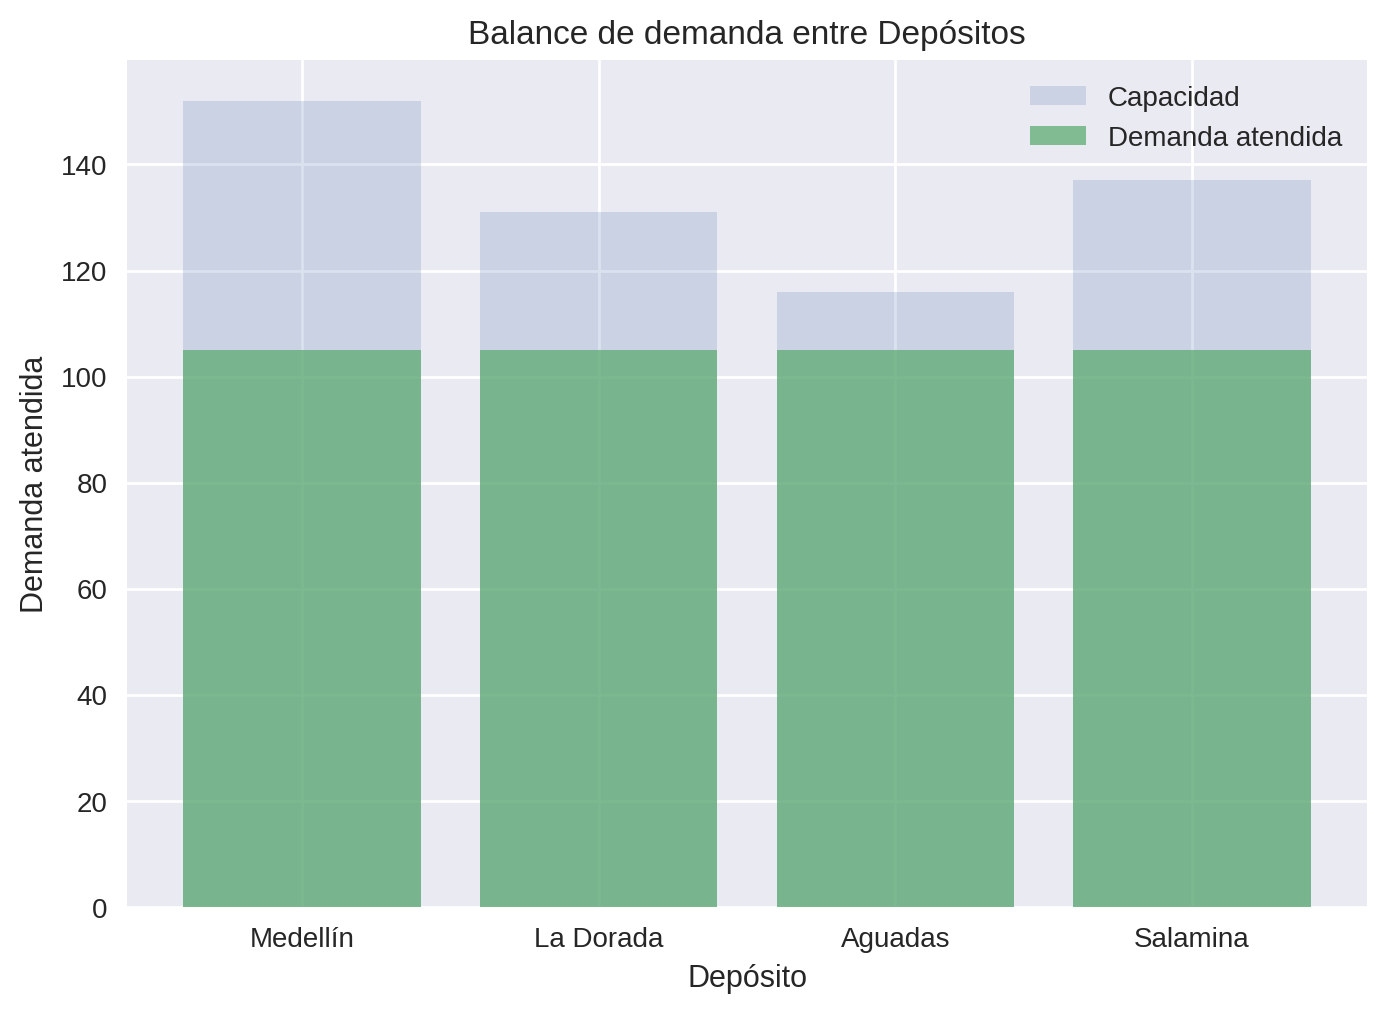

In [38]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'
plt.style.use("seaborn")

utilizado = []
for i in Depositos:
    utilizado.append(sum(produccion[j] * x[i, j].value() for j in Centros))

plt.bar(
    Depositos, [cap - 1 for cap in capacidad.values()], alpha=0.2, label="Capacidad"
)
plt.bar(Depositos, utilizado, alpha=0.7, label="Demanda atendida")
plt.legend()
plt.xlabel("Depósito")
plt.ylabel("Demanda atendida")
plt.title("Balance de demanda entre Depósitos")
plt.show()

## Opcional (0 puntos)

*Una vez esté listo el modelo, puedes cambiar los valores de los parámetros a continuación para verificar cómo cambian las soluciones y la función objetivo. Para esto debes correr nuevamente las celdas que crean el modelo desde el principio*

In [39]:
# Parámetros modificables
q = 300                 # En miles de toneladas por km
mejor_costo = 24320009  # Función objetivo del caso de minimizacion de costos

**Reflexión**: ¿Qué aspecto particular puedes notar en la visualización de la solución? ¿Crees que está relacionado con la función objetivo?

### Fin del laboratorio
---
Cuando hayas finalizado las preguntas, debes presionar el botón "Enviar tarea" en la parte superior.

Después de enviar el laboratorio, debes esperar algunos minutos para que se cargue la nota en Coursera.
¡Muchos éxitos!